In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install transformers

     |████████████████████████████████| 2.1MB 16.0MB/s 
     |████████████████████████████████| 3.3MB 56.6MB/s 
     |████████████████████████████████| 870kB 46.3MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.44-cp37-none-any.whl size=886084 sha256=e4f7ba1fe32110fc3d13805039d3b7a9a378f46c546fecbaced90c4e4cc1e01b
  Stored in directory: /root/.cache/pip/wheels/3e/fb/c0/13ab4d63d537658f448366744654323077c4d90069b6512f3c
Successfully built sacremoses


In [3]:
import torch
from transformers import AutoTokenizer, AutoModel
# from bertmoji_model import * 

import os
from copy import copy
import logging
import pandas as pd
import pytz
import argparse
from datetime import datetime as dt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score, accuracy_score
from torch.utils.data import Dataset, DataLoader, TensorDataset, RandomSampler
from transformers import AutoTokenizer, AutoModel


MODEL = "cardiffnlp/twitter-roberta-base"
LABEL_MAPPING = {1.0:'Y', 0.0:'N'}

In [4]:
class bertmoji(nn.Module):
    '''
    RoBERTa  model that adds a linear layer for binary classification.
    '''
    def __init__(self, roberta, num_classes=1):
        super().__init__()
        self.roberta = roberta
        self.dropout = nn.Dropout(roberta.config.hidden_dropout_prob)
        self.W = nn.Linear(roberta.config.hidden_size, num_classes)
    def forward(self, input_ids, attention_mask):
        h_cls = self.roberta(input_ids=input_ids, attention_mask=attention_mask)[1]
        logits = self.dropout(self.W(h_cls))
        return logits

In [5]:
def load_model(checkpoint_path):
    '''
    helper function for loading model, training + validation performance
    and tokenizer in one-go
    '''
    if torch.cuda.is_available():
        checkpoint = torch.load(checkpoint_path)
    else:
        checkpoint = torch.load(checkpoint_path, map_location='cpu')
    train_performance = checkpoint['train_performance']
    valid_performance = checkpoint['valid_performance']
    model = AutoModel.from_pretrained(MODEL)
    tokenizer = AutoTokenizer.from_pretrained(MODEL)
    # necessary for correctly loading checkpoint
    tokenizer.add_tokens(["[USER]"])
    model.resize_token_embeddings(len(tokenizer)) 

    bertmoji_classifier = bertmoji(model)
    bertmoji_classifier.load_state_dict(checkpoint['model'])
    return bertmoji_classifier, tokenizer, train_performance, valid_performance

In [6]:
model, tokenizer, train_perf, valid_perf = load_model('/content/drive/MyDrive/2021_NLU/BERT/full-bertmoji.pt')

In [8]:
# df_val = pd.read_csv('/content/drive/MyDrive/2021_NLU/data/full_data/emoji_nsp_dataset_valid.csv')
# df_val.head()
# x = list(zip(df_val['tweets'], df_val['emoji_sentence']))

In [7]:
df_test = pd.read_csv('/content/drive/MyDrive/2021_NLU/data/full_data/emoji_nsp_dataset_test.csv')

In [9]:
test_list = list(zip(df_test['tweets'], df_test['emoji_sentence']))
# test_list_follows = list(df_test['follows?'])

In [10]:
def run_batch(model, data, tokenizer, device, human_readable=False):
    '''
    wrap tokenize_data in a single test-execution, return results in a dataframe
    for analysis
    '''
    dataset, df = tokenize_data(data, tokenizer, return_df=True)
    # dataset, df = tokenize_data(data, tokenizer)
    loader = DataLoader(dataset, batch_size=1)
    model.eval()
    model.to(device)
    predictions = []
    prob = []

    for step, batch in enumerate(loader):
        batch = tuple(t.to(device) for t in batch)
        input_ids, attention_masks = batch
        logits = model(input_ids, attention_masks)
        logits = logits.to(device)

        logits_prob = torch.sigmoid(logits)

        preds = torch.round(torch.sigmoid(logits))

        predictions.append(preds.item())
        prob.append(logits_prob.item())

    df['predictions'] = predictions
    df['probability'] = prob

    if human_readable:
        df['predictions'] = df['predictions'].map(LABEL_MAPPING)
        # df['probability'] = 
    return df

In [12]:
def tokenize_data(data, tokenizer, return_df=False):
    '''
    function to tokenize tweets and emoji sentence, also creates attention mask.
    data is returned as a TensorDataset.
    '''
    df_ = pd.DataFrame(data, columns = ['tweet', 'emoji_sentence'])
    tweets = df_['tweet'] + ' ' + tokenizer.sep_token + ' ' + df_['emoji_sentence']
    max_sentence_length = tweets.str.len().max()
    tokenized_tweets = []
    attn_masks = []
    for idx, tweet in tweets.items():
        encoded = tokenizer.encode_plus(tweet, padding='max_length',
                                        truncation=True, max_length=max_sentence_length)
        tokenized_tweets.append(encoded['input_ids'])
        attn_masks.append(encoded['attention_mask'])
    tokenized_tweets = torch.tensor(tokenized_tweets, dtype=torch.long)
    attn_masks = torch.tensor(attn_masks, dtype=torch.long)
    if return_df:
        return TensorDataset(tokenized_tweets, attn_masks), df_
    else:
        return TensorDataset(tokenized_tweets, attn_masks)

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
results_test = run_batch(model, test_list, tokenizer, device, human_readable=True)

In [ ]:
results_test.to_csv('/content/drive/MyDrive/2021_NLU/data/full_data/results_test.csv', index=False)

In [16]:
results_test = pd.read_csv('/content/drive/MyDrive/2021_NLU/data/full_data/results_test.csv')

In [38]:
results_test.iloc[0]

tweet             You’re just so beautiful 
emoji_sentence                            💀
predictions                               N
probability                        0.864561
true_value                                0
Name: 0, dtype: object

In [17]:
results_test['true_value'] = df_test['follows?'].values
results_test

,tweet,emoji_sentence,predictions,probability,true_value
0,You’re just so beautiful,💀,N,0.135439,0
1,Watch your PH balance not my page,🙂,Y,0.809802,1
2,fast gcash • follow me &amp; [USER] • rt end...,💸💸⏳,Y,0.826873,1
3,Want to tease someone until they cry,😢,Y,0.690209,1
4,I’ll figure this out. I always do and I always...,😤,N,0.104652,1
...,...,...,...,...,...
4433,Learning to LOVE yourself the RIGHT away it th...,🥰,Y,0.892988,1
4434,[USER] Follow me to gainFollowersDaily.,👻🐰🌹,Y,0.870953,1
4435,I would never let a female use a strap because...,😍,N,0.065642,0
4436,[USER] We downgraded our CSP to the Flex last ...,😬,Y,0.821872,1


In [19]:
# results_test[results_test['predictions'] == 'N']

def normalized_prob(predictions, probability):
  if predictions == 'N':
    return 1 - probability
  else:
    return probability

results_test['probability'] = results_test[['predictions', 'probability']].apply(lambda x: normalized_prob(*x), axis=1)

In [20]:
results_test['true_value'] = df_test['follows?'].values
results_test

,tweet,emoji_sentence,predictions,probability,true_value
0,You’re just so beautiful,💀,N,0.864561,0
1,Watch your PH balance not my page,🙂,Y,0.809802,1
2,fast gcash • follow me &amp; [USER] • rt end...,💸💸⏳,Y,0.826873,1
3,Want to tease someone until they cry,😢,Y,0.690209,1
4,I’ll figure this out. I always do and I always...,😤,N,0.895348,1
...,...,...,...,...,...
4433,Learning to LOVE yourself the RIGHT away it th...,🥰,Y,0.892988,1
4434,[USER] Follow me to gainFollowersDaily.,👻🐰🌹,Y,0.870953,1
4435,I would never let a female use a strap because...,😍,N,0.934358,0
4436,[USER] We downgraded our CSP to the Flex last ...,😬,Y,0.821872,1


In [23]:
incorrect_neg = results_test[(results_test['predictions'] == 'N') & (results_test['true_value'] == 1)].sort_values(by='probability', ascending = False)
incorrect_neg.head(10)

,tweet,emoji_sentence,predictions,probability,true_value
2368,i feel so guilty rn,🧎🏿,N,0.973737,1
264,Enjoying the moment,🤒,N,0.967404,1
1840,there's no way hope is THAT obsessed with a gu...,✋🏻,N,0.964489,1
2979,anyway please do not repost fics without the w...,💀,N,0.962740,1
1746,[USER] Holy P1 is spreading fast,💩😔,N,0.951668,1
4238,not sure who needs to hear this but in order t...,🤍,N,0.948261,1
2599,"my life is getting boring, who should i cut of...",💓,N,0.947895,1
4180,yes I SHOULD be writing no I am NOT doing that,❤,N,0.947359,1
3354,"""Suju has no fans"" elfs speaks with numbers dear",💅,N,0.944762,1
3179,minho said on there’s a secret in the pic he ...,💭,N,0.944517,1


In [43]:
incorrect_pos = results_test[(results_test['predictions'] == 'Y') & (results_test['true_value'] == 0)].sort_values(by='probability', ascending = False)
incorrect_pos.head(20)

,tweet,emoji_sentence,predictions,probability,true_value
3207,VII will always hold a special place in my hea...,🧏🏾♂,Y,0.975576,0
1903,️‍⃠ ️‍⃠ these exist,🤷🏽♀,Y,0.971158,0
3937,Everytime I turn around HE’S making a way Tha...,🤍,Y,0.944826,0
3198,[USER] Hello! It's a pleasure for us that you'...,🤦🏻♀,Y,0.942299,0
2745,What a cutie!,😍,Y,0.934477,0
1010,[USER] have a nice day,💖,Y,0.931376,0
2002,"[USER] Oh, this is what true love looks like! ...",😍,Y,0.930228,0
515,00:00 i love you my jiminie [USER],💕,Y,0.928533,0
762,My irl friend is so nice I love her,😙,Y,0.926666,0
3224,[USER] happy thursday morning ! don't skip ur ...,🧡,Y,0.924809,0


In [45]:
print(df_test.iloc[2002])
print("===========")
print(df_test.iloc[2745])
print("===========")
print(df_test.iloc[1010])
print("===========")
print(df_test.iloc[762])
print("===========")
print(df_test.iloc[3764])

index                                                         76818
tweets            [USER] Oh, this is what true love looks like! ...
emoji_sentence                                                    😍
follows?                                                          0
Name: 2002, dtype: object
index                      84813
tweets            What a cutie! 
emoji_sentence                 😍
follows?                       0
Name: 2745, dtype: object
index                               80561
tweets            [USER] have a nice day 
emoji_sentence                          💖
follows?                                0
Name: 1010, dtype: object
index                                            76659
tweets            My irl friend is so nice I love her 
emoji_sentence                                       😙
follows?                                             0
Name: 762, dtype: object
index                      86438
tweets            [USER] love u 
emoji_sentence                 💜
follow

In [44]:
print(df_test.shape)
print(incorrect_neg.shape)
print(incorrect_pos.shape)


(4438, 4)
(329, 5)
(1082, 5)


(array([68., 37., 46., 32., 32., 26., 35., 22., 18., 13.]),
 array([0.50079587, 0.54808993, 0.595384  , 0.64267806, 0.68997212,
        0.73726619, 0.78456025, 0.83185432, 0.87914838, 0.92644244,
        0.97373651]),
 <a list of 10 Patch objects>)

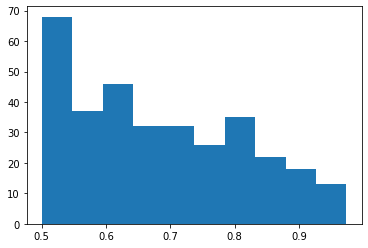

In [ ]:
import matplotlib.pyplot as plt

plt.hist(incorrect_neg.probability)

(array([ 97., 132., 126., 147., 139., 139., 146., 101.,  47.,   8.]),
 array([0.50021863, 0.5477544 , 0.59529016, 0.64282593, 0.69036169,
        0.73789746, 0.78543322, 0.83296899, 0.88050475, 0.92804052,
        0.97557628]),
 <a list of 10 Patch objects>)

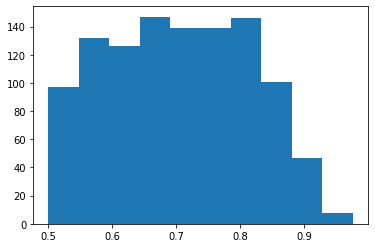

In [ ]:
plt.hist(incorrect_pos.probability)

In [27]:
# results['emoji_sentence_len'] = results['emoji_sentence'].apply(lambda x: len(x))
# results.describe()
